In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
base_path = '/content/drive/MyDrive/ds_Prince_Panwar'
os.makedirs(f'{base_path}/csv_files', exist_ok=True)
os.makedirs(f'{base_path}/outputs', exist_ok=True)

## Trader Behaviour and market Sentiment Analysis

- 1. Data Loading and Initial Exploration
- 2. Data Cleaning and preprocessing
- 3. Exploratory Data Analysis
- 4. Statistical analysis
- 5. Advanced Analysis (machine learning)
- 6. Conclusions and Recommendations

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


# Set Visualization Style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

#Data Loading


In [4]:
trader_data = pd.read_csv('/content/drive/MyDrive/ds_Prince_Panwar/csv_files/historical_data.csv')
sentiment_data = pd.read_csv('/content/drive/MyDrive/ds_Prince_Panwar/csv_files/fear_greed_index.csv')

# Initial Data Exploration

**Sentiment data initial exploration**

In [5]:
print(sentiment_data.head())
print(sentiment_data.info())
print(sentiment_data.describe())
print(sentiment_data['classification'].value_counts())

    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
None
          timestamp        value
count  2.644000e+03  2644.000000
mean   1.631899e+09    46.981089
std    6.597967e+07    21.827680
min    1.517463e+09     5.000000
25%    1.574811e+09    28.000000
50%    1.631900e+09    46.000000
75%    1.688989e+09    66.000000
max    1.746164e+09   

**Trader data (historical data) initial analysis**

In [7]:
print(trader_data.head())
print(trader_data.info())
print(trader_data.describe(include='all'))

                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec0945

# Data Cleaning and Preparation

**cleaning sentiment data**

In [8]:
# Convert date to datetime format
sentiment_data['date'] = pd.to_datetime(sentiment_data['date'])

# Check for missing dates
date_range = pd.date_range(start=sentiment_data['date'].min(), end=sentiment_data['date'].max())
missing_dates = date_range.difference(sentiment_data['date'])
print(f"Missing dates: {len(missing_dates)}")
print(missing_dates)


Missing dates: 4
DatetimeIndex(['2018-04-14', '2018-04-15', '2018-04-16', '2024-10-26'], dtype='datetime64[ns]', freq=None)


In [9]:
# Set the date column as the index
sentiment_data_indexed = sentiment_data.set_index('date')

# Create a complete date range
date_range = pd.date_range(start=sentiment_data_indexed.index.min(), end=sentiment_data_indexed.index.max(), freq='D')

# Reindex the DataFrame to include missing dates and fill missing 'value' using interpolation
sentiment_data_filled = sentiment_data_indexed.reindex(date_range)
sentiment_data_filled['value'] = sentiment_data_filled['value'].interpolate(method='time')

# For 'classification', we can forward fill the missing values or use a placeholder
sentiment_data_filled['classification'] = sentiment_data_filled['classification'].ffill()

# Reset index to make 'date' a column again
sentiment_data_filled = sentiment_data_filled.reset_index().rename(columns={'index': 'date'})

print("Sentiment data after filling missing dates:")
display(sentiment_data_filled.head())
display(sentiment_data_filled.info())

Sentiment data after filling missing dates:


,date,timestamp,value,classification
0,2018-02-01,1.517463e+09,30.0,Fear
1,2018-02-02,1.517549e+09,15.0,Extreme Fear
2,2018-02-03,1.517636e+09,40.0,Fear
3,2018-02-04,1.517722e+09,24.0,Extreme Fear
4,2018-02-05,1.517809e+09,11.0,Extreme Fear


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2648 entries, 0 to 2647
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            2648 non-null   datetime64[ns]
 1   timestamp       2644 non-null   float64       
 2   value           2648 non-null   float64       
 3   classification  2648 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 82.9+ KB


None

**cleaning trader (historical data)
**

In [10]:
# Convert time to datetime
trader_data['Timestamp IST'] = pd.to_datetime(trader_data['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')

# Extract date for merging
trader_data['date'] = trader_data['Timestamp IST'].dt.date

# Handle missing values
print(trader_data.isnull().sum())

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
date                0
dtype: int64


In [11]:
# Fill missing numerical columns with the median
numerical_cols = ['Order ID', 'Fee', 'Trade ID', 'Timestamp']
for col in numerical_cols:
    trader_data[col].fillna(trader_data[col].median(), inplace=True)

# Fill missing categorical columns with the mode
categorical_cols = ['Crossed']
for col in categorical_cols:
    trader_data[col].fillna(trader_data[col].mode()[0], inplace=True)

# Verify that missing values have been filled
print("Missing values after filling:")
print(trader_data.isnull().sum())


Missing values after filling:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
date                0
dtype: int64


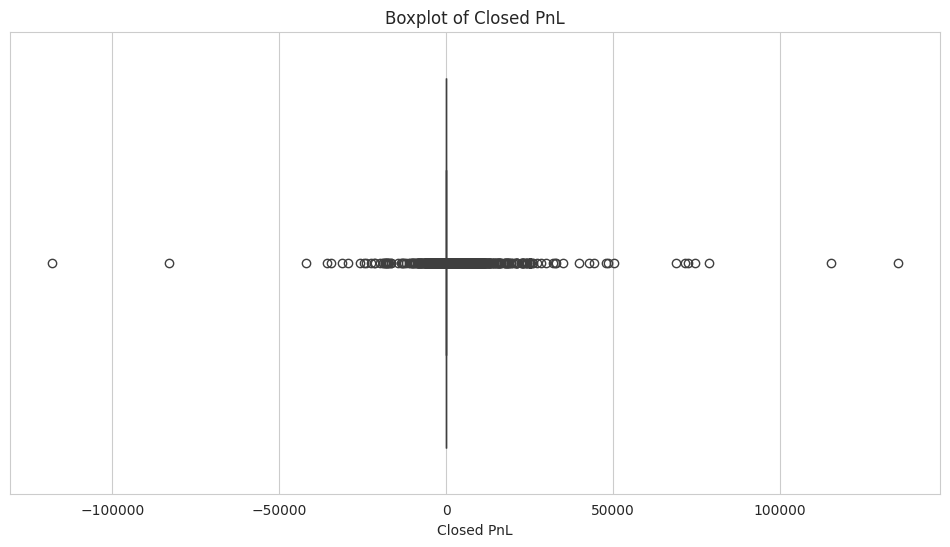

<Figure size 1200x600 with 0 Axes>

In [12]:
# Check for outliers in numerical columns like closedPnL
sns.boxplot(x=trader_data['Closed PnL'])
plt.title('Boxplot of Closed PnL')
plt.show()
plt.savefig('/content/drive/MyDrive/ds_Prince_Panwar/outputs/boxplot_closed_pnl.png') # Save the plot

# We might want to cap extreme values
upper_limit = trader_data['Closed PnL'].quantile(0.99)
lower_limit = trader_data['Closed PnL'].quantile(0.01)
trader_data['Closed PnL'] = np.where(trader_data['Closed PnL'] > upper_limit, upper_limit,
                                  np.where(trader_data['Closed PnL'] < lower_limit, lower_limit,
                                          trader_data['Closed PnL']))

# Feature Engineering

In [13]:
# 1. Daily aggregate metrics per account for trader data
daily_trader_stats = trader_data.groupby(['Account', 'date']).agg(
    total_closed_pnl=('Closed PnL', 'sum'),
    mean_closed_pnl=('Closed PnL', 'mean'),
    trade_count=('Closed PnL', 'count'),
    total_size_usd=('Size USD', 'sum')
).reset_index()

# 2. Categorize traders by performance based on total daily PnL
if daily_trader_stats['total_closed_pnl'].nunique() >= 3:
    daily_trader_stats['performance_category'] = pd.qcut(
        daily_trader_stats['total_closed_pnl'],
        q=3,
        labels=['low', 'medium', 'high'],
        duplicates='drop' # Handle cases with many identical values
    )
else:
    # Handle cases with not enough unique values, perhaps by creating broader categories
    print("Not enough unique total_closed_pnl values to create 3 quantiles. Skipping performance categorization.")
    daily_trader_stats['performance_category'] = 'not_categorized'

print("Daily Trader Stats with Performance Category:")
display(daily_trader_stats.head())



Daily Trader Stats with Performance Category:


,Account,date,total_closed_pnl,mean_closed_pnl,trade_count,total_size_usd,performance_category
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.000000,0.000000,177,900880.13,low
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.000000,0.000000,68,542413.18,low
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.000000,0.000000,40,949380.00,low
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-1497.671385,-124.805949,12,338240.00,low
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.100000,59.374074,27,465700.00,high


In [14]:
# 3. Create a numerical sentiment score for sentiment data
# Used the sentiment_data_filled DataFrame
sentiment_score_map = {
    'Extreme Fear': 10,
    'Fear': 30,
    'Neutral': 50,
    'Greed': 70,
    'Extreme Greed': 90
}
sentiment_data_filled['sentiment_score'] = sentiment_data_filled['classification'].map(sentiment_score_map)

sentiment_data_filled['classification_score'] = sentiment_data_filled['classification'].map(sentiment_score_map)


print("\nSentiment Data with Numerical Score:")
display(sentiment_data_filled.head())


Sentiment Data with Numerical Score:


,date,timestamp,value,classification,sentiment_score,classification_score
0,2018-02-01,1.517463e+09,30.0,Fear,30,30
1,2018-02-02,1.517549e+09,15.0,Extreme Fear,10,10
2,2018-02-03,1.517636e+09,40.0,Fear,30,30
3,2018-02-04,1.517722e+09,24.0,Extreme Fear,10,10
4,2018-02-05,1.517809e+09,11.0,Extreme Fear,10,10


# Merging the Datasets


In [15]:
# Ensure date columns are in datetime format (already done in previous steps, but good practice to confirm)
daily_trader_stats['date'] = pd.to_datetime(daily_trader_stats['date'])
sentiment_data_filled['date'] = pd.to_datetime(sentiment_data_filled['date'])


# Merge on date
merged_data = pd.merge(daily_trader_stats, sentiment_data_filled[['date', 'value', 'classification', 'sentiment_score', 'classification_score']],
                      on='date',
                      how='left')

print("Merged Data Head:")
display(merged_data.head())
print("\nMerged Data Info:")
display(merged_data.info())

Merged Data Head:


,Account,date,total_closed_pnl,mean_closed_pnl,trade_count,total_size_usd,performance_category,value,classification,sentiment_score,classification_score
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.000000,0.000000,177,900880.13,low,76.0,Extreme Greed,90,90
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.000000,0.000000,68,542413.18,low,90.0,Extreme Greed,90,90
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.000000,0.000000,40,949380.00,low,83.0,Extreme Greed,90,90
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-1497.671385,-124.805949,12,338240.00,low,94.0,Extreme Greed,90,90
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.100000,59.374074,27,465700.00,high,79.0,Extreme Greed,90,90



Merged Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Account               2341 non-null   object        
 1   date                  2341 non-null   datetime64[ns]
 2   total_closed_pnl      2341 non-null   float64       
 3   mean_closed_pnl       2341 non-null   float64       
 4   trade_count           2341 non-null   int64         
 5   total_size_usd        2341 non-null   float64       
 6   performance_category  2341 non-null   category      
 7   value                 2341 non-null   float64       
 8   classification        2341 non-null   object        
 9   sentiment_score       2341 non-null   int64         
 10  classification_score  2341 non-null   int64         
dtypes: category(1), datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 185.4+ KB


None

In [16]:
# Save the merged DataFrame to a CSV file
merged_data.to_csv('/content/drive/MyDrive/ds_Prince_Panwar/csv_files/merged_trader_sentiment_data.csv', index=False)

print("Merged data saved to merged_trader_sentiment_data.csv")

Merged data saved to merged_trader_sentiment_data.csv


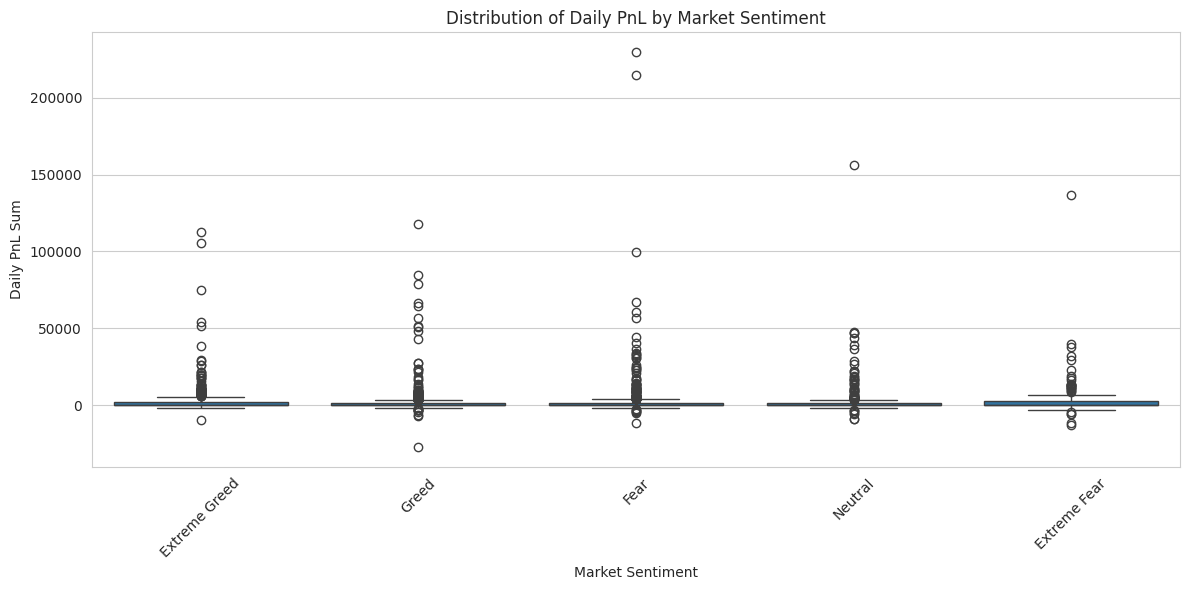

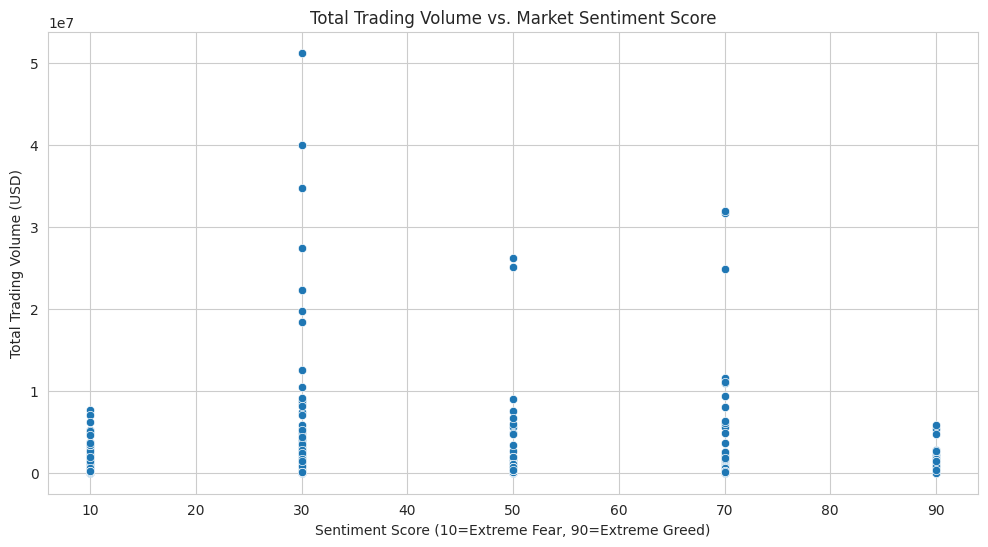

In [17]:
# Distribution of Daily PnL by Market Sentiment
plt.figure(figsize=(12, 6))
sns.boxplot(x='classification', y='total_closed_pnl', data=merged_data)
plt.title('Distribution of Daily PnL by Market Sentiment')
plt.ylabel('Daily PnL Sum')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ds_Prince_Panwar/outputs/pnl_by_sentiment_boxplot.png') # Save the plot
plt.show()


# Trading Volume vs. Market Sentiment Score
plt.figure(figsize=(12, 6))
sns.scatterplot(x='sentiment_score', y='total_size_usd', data=merged_data)
plt.title('Total Trading Volume vs. Market Sentiment Score')
plt.ylabel('Total Trading Volume (USD)')
plt.xlabel('Sentiment Score (10=Extreme Fear, 90=Extreme Greed)')
plt.grid(True)
plt.savefig('/content/drive/MyDrive/ds_Prince_Panwar/outputs/volume_vs_sentiment_scatterplot.png') # Save the plot
plt.show()


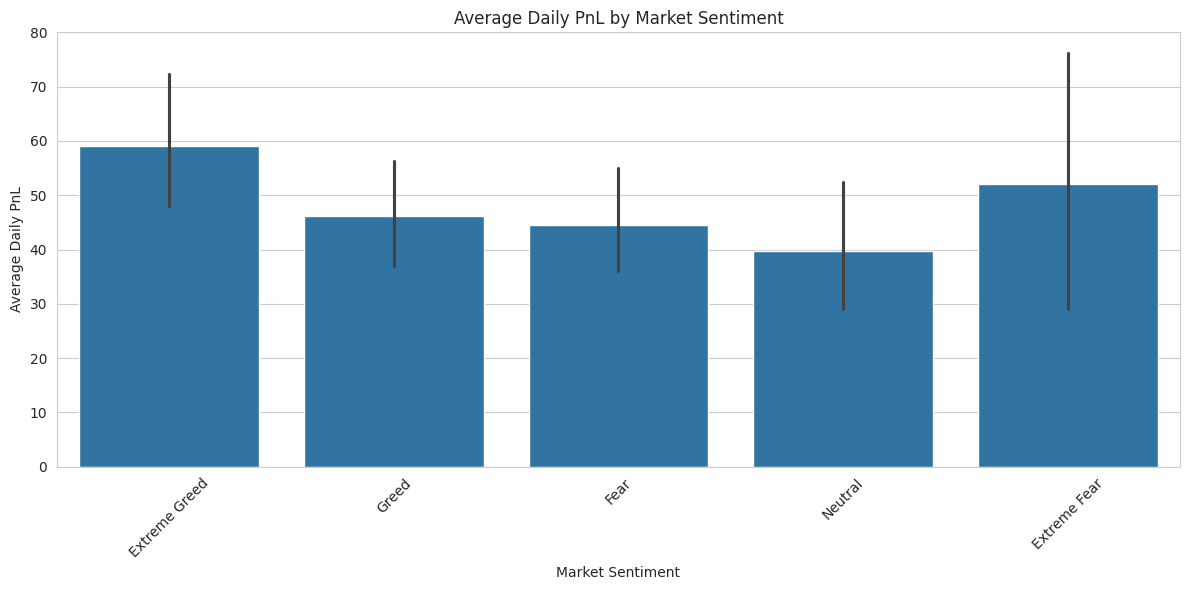

In [18]:
# Average PnL by Sentiment, Trade Count by Sentiment, etc.
plt.figure(figsize=(12, 6))
sns.barplot(x='classification', y='mean_closed_pnl', data=merged_data)
plt.title('Average Daily PnL by Market Sentiment')
plt.ylabel('Average Daily PnL')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ds_Prince_Panwar/outputs/avg_pnl_by_sentiment_barplot.png') # Save the plot
plt.show()

# Advanced Analysis: Correlation and Time Series Analysis

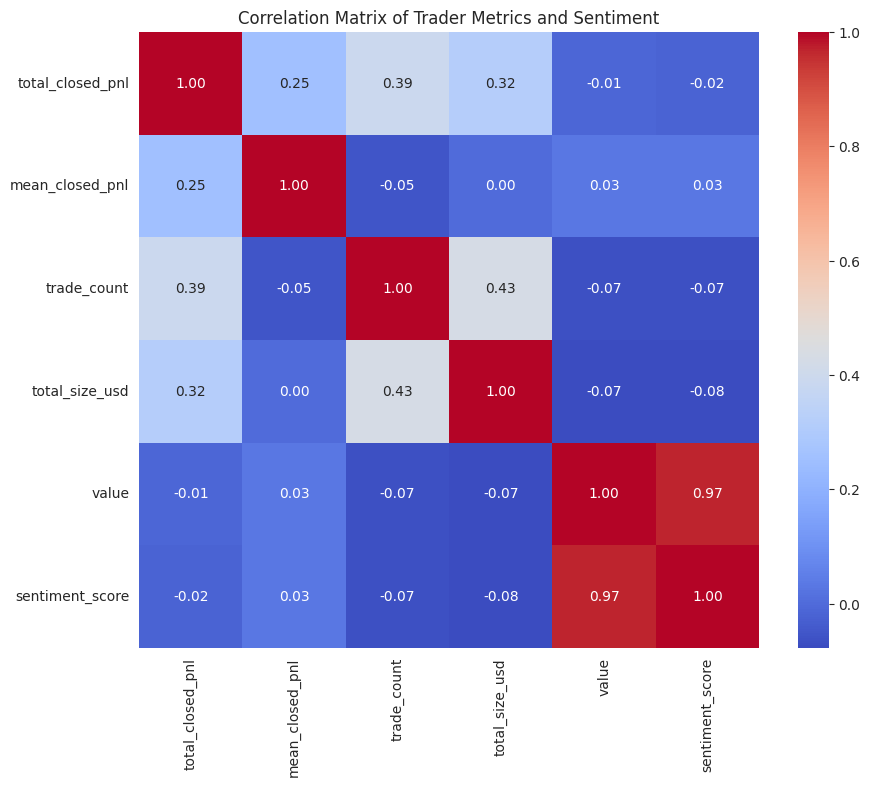

In [19]:
# Correlation Analysis
correlation_cols = ['total_closed_pnl', 'mean_closed_pnl', 'trade_count', 'total_size_usd', 'value', 'sentiment_score']

# Calculate the correlation matrix
correlation_matrix = merged_data[correlation_cols].corr()

# Display the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Trader Metrics and Sentiment')
plt.savefig('/content/drive/MyDrive/ds_Prince_Panwar/outputs/correlation_matrix_heatmap.png') # Save the plot
plt.show()



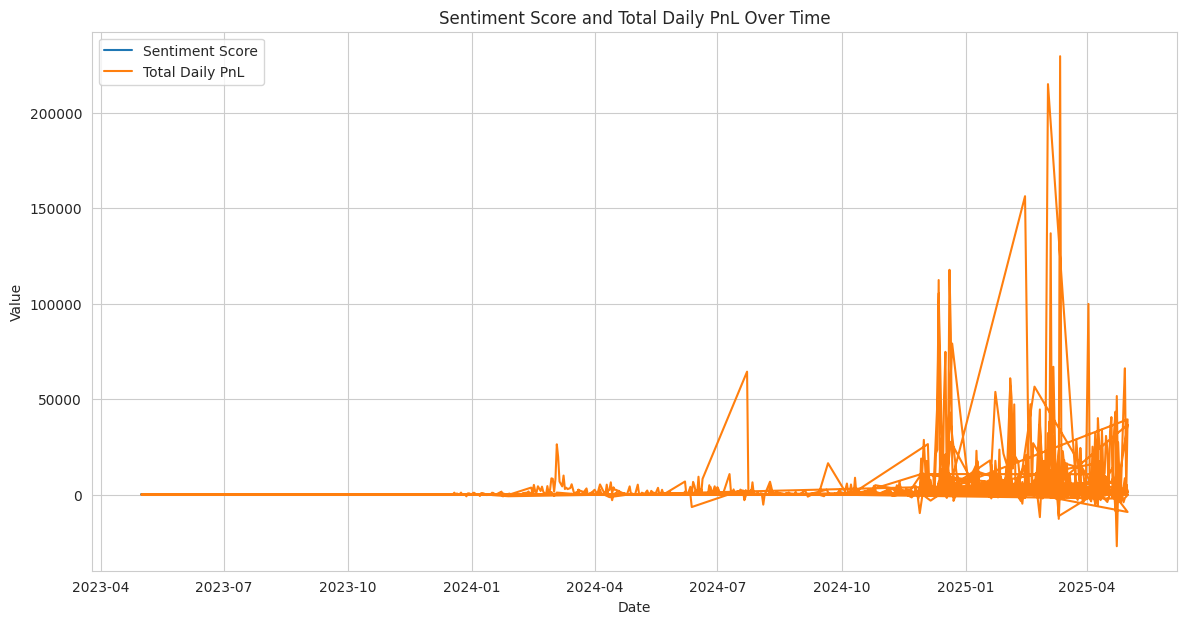

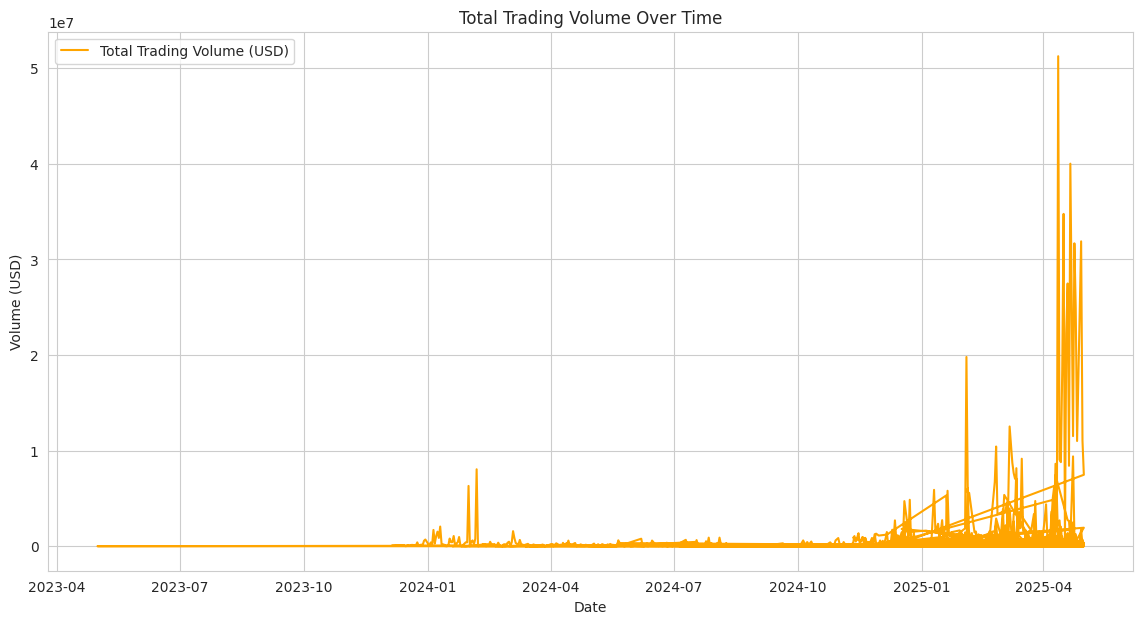

In [20]:
# Time Series Analysis
merged_data_ts = merged_data.set_index('date')

# Plot time series for sentiment score and total daily PnL
plt.figure(figsize=(14, 7))
plt.plot(merged_data_ts['sentiment_score'], label='Sentiment Score')
plt.plot(merged_data_ts['total_closed_pnl'], label='Total Daily PnL')
plt.title('Sentiment Score and Total Daily PnL Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/ds_Prince_Panwar/outputs/sentiment_pnl_timeseries.png') # Save the plot
plt.show()

# You can add more time series plots for other metrics like total_size_usd or trade_count
plt.figure(figsize=(14, 7))
plt.plot(merged_data_ts['total_size_usd'], label='Total Trading Volume (USD)', color='orange')
plt.title('Total Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume (USD)')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/ds_Prince_Panwar/outputs/volume_timeseries.png') # Save the plot
plt.show()

# Advanced Analysis: Machine Learning

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare data for modeling
X = merged_data[['total_size_usd', 'sentiment_score']].dropna()
y = merged_data['total_closed_pnl'].loc[X.index]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Model MSE: {mse:.2f}")

# Feature importance
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print(importance)

Model MSE: 180835517.64
           Feature  Importance
0   total_size_usd    0.885273
1  sentiment_score    0.114727
